In [1]:
from data import series_data
from importlib import import_module
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
from util import train, plot_confusion_matrix, plot_loss_accuracy, plot_dataloader_distribution
import matplotlib.pyplot as plt 
import numpy as np 

/home/giulia/SaltAndPepper/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_name = 'Casilino'
model_name = 'FullyConnectedNetwork'
rearrange_tensor = False
units = 10
layers = 3
batch = 200
epochs = 30
device = 'cpu'

Dataset already assembled in /home/giulia/Documenti/ecgproject/datasets/Casilino.
torch.Size([525, 1, 15000])
Dataset already assembled in /home/giulia/Documenti/ecgproject/datasets/Casilino.
The number of samples for training is 420.
Samples per classes: [0.6514285714285715, 0.30666666666666664, 0.030476190476190476, 0.011428571428571429]
Samples per classes (training): [0.638095238095238, 0.32142857142857145, 0.030952380952380953, 0.009523809523809525]
Samples per classes (validation): [0.7047619047619048, 0.24761904761904763, 0.02857142857142857, 0.01904761904761905]
The number of parameters is 150274.


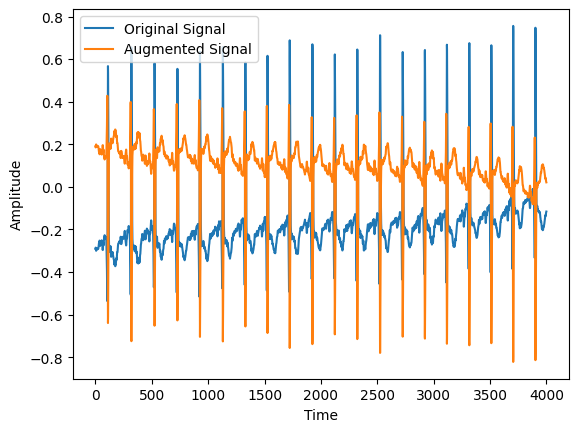

In [11]:
dataset = import_module('datasets.' + dataset_name)
model = getattr(import_module('model'), model_name)

ts, labels = dataset.load_data()
if rearrange_tensor:
    ts = ts.transpose(1, 2)

ts_squeezed= ts.squeeze(1)
print(ts.shape)
indice=6
patient=ts[indice,:].squeeze(0)
patient_n=patient.numpy()
fig, ax1 = plt.subplots(1, 1)
ax1.plot(np.arange(4000),patient_n[1000:5000], label='Original Signal')
ax1.set_xlabel('Time')
ax1.set_ylabel('Amplitude')
    
n_labels = int(labels.max()) + 1
label_names = dataset.get_label_names()
data = series_data.Series(ts, labels, {'RandomScaling':[0.5],'RandomAmplitudeFlip':[0.5],'RandomBiasShift':[0.5], 'RandomOscillationAdd': [0]})
train_size = int(0.8 * len(data))
valid_size = len(data) - train_size
train_data, valid_data = random_split(data, [train_size, valid_size])
train_loader = DataLoader(train_data, batch_size=batch, shuffle=True)
validation_loader = DataLoader(valid_data, batch_size=batch, shuffle=False)

net = model(num_classes=n_labels, input_len=ts.size(2), 
                            hidden_units=units, hidden_layers=layers).to(device)
print(f'The number of samples for training is {train_size}.')
class_samples = [int(sum(labels==l))/len(labels) for l in range(n_labels)]
print(f'Samples per classes: {class_samples}')
class_samples_train = [sum([int(t[1])==l for t in list(train_data)])/len(list(train_data)) for l in range(n_labels)]
print(f'Samples per classes (training): {class_samples_train}')
class_samples_valid = [sum([int(v[1])==l for v in list(valid_data)])/len(list(valid_data)) for l in range(n_labels)]
print(f'Samples per classes (validation): {class_samples_valid}')
print(f'The number of parameters is {sum(p.numel() for p in net.parameters())}.')

ax1.plot(np.arange(4000),data.__getitem__(6)[0][0].numpy()[1000:5000] , label='Augmented Signal')
ax1.legend()

In [12]:
print(train_loader)

In [ ]:
plot_dataloader_distribution(train_loader, label_names)

In [9]:
class_weights = [1/sum([int(t[1])==l for t in list(train_data)]) for l in range(n_labels)]
sample_weights = [class_weights[int(t[1])] for t in list(train_data)]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(train_data), replacement=True)
rebalanced_loader = DataLoader(train_data, sampler=sampler, batch_size=batch)

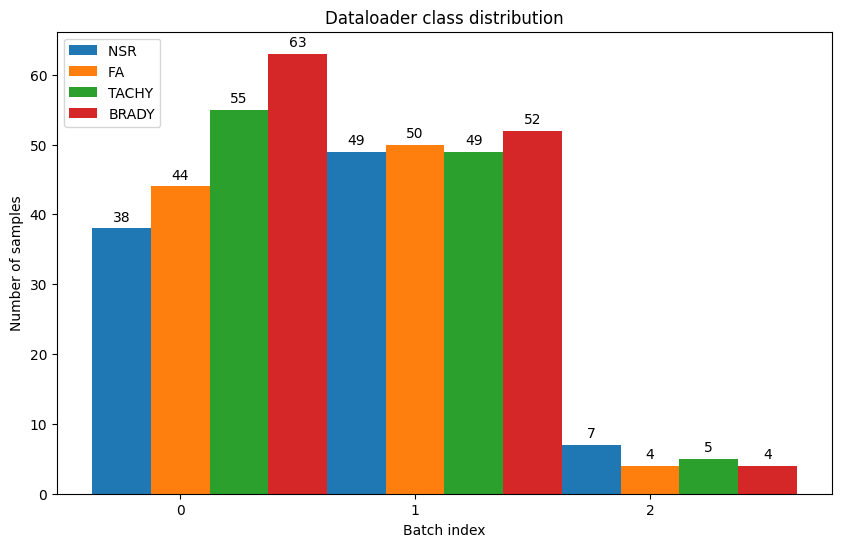

In [10]:
plot_dataloader_distribution(rebalanced_loader, label_names)

In [11]:
train_loss, train_acc, validation_loss, validation_acc, predictions, targets = train(
    net, device, rebalanced_loader, validation_loader, epochs, lr=0.01)

Training: 100%|███████████████████| 20/20 [00:12<00:00,  1.61epoch/s, loss=1.51]


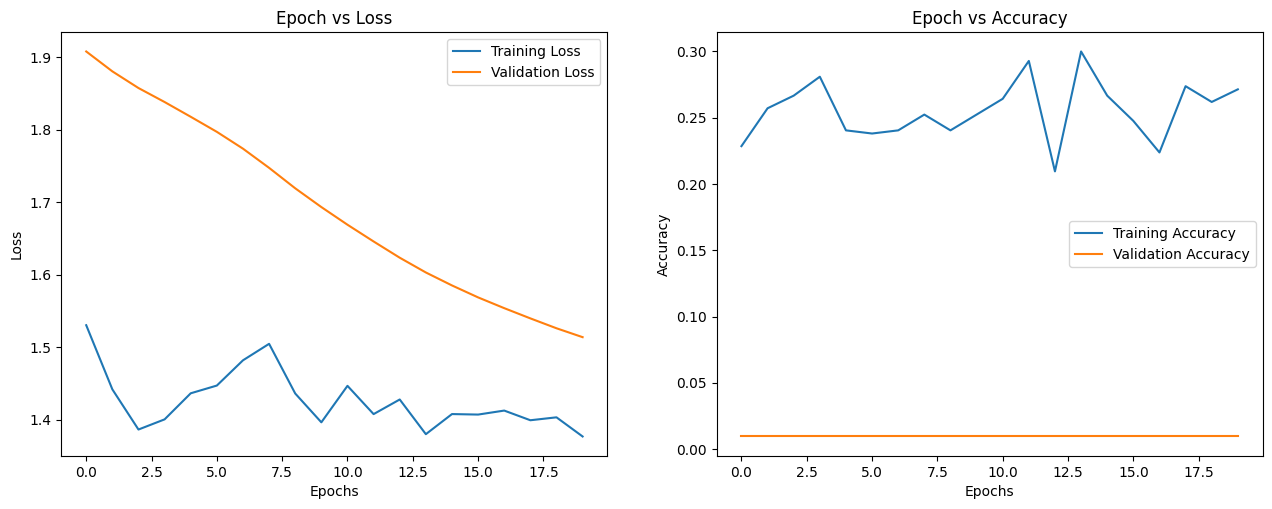

In [12]:
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)


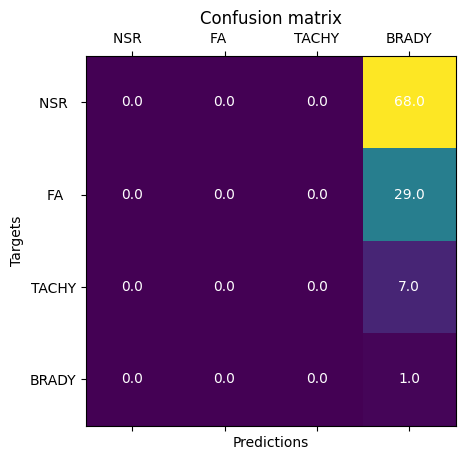

In [13]:
plot_confusion_matrix(targets, predictions, label_names)